# Evaluation of prior elicitation

_David Selby, Kaiserslautern, 1 February 2024_

In this notebook, we evaluate the quality of prior distributions obtained from the LLM, comparing them with real data.

## Import data

Let's import some data from a file.

In [1]:
import pandas as pd
from pathlib import Path
import json

def load_ndjson(filename):
    data = []
    with open(filename, 'r') as f:
        for line in f:
            obj = json.loads(line.strip())
            data.append(obj)
    return data

def jsonlist_to_df(jsonlist):
    dflist = map(pd.DataFrame, jsonlist)
    return pd.concat(dflist).reset_index()

def read_ndjson(filename):
    data = load_ndjson(filename)
    return jsonlist_to_df(data)

data_dirpath = Path('../../data')
weather_filepath = data_dirpath / 'cities/cities.csv'
meta_filepath = data_dirpath / 'cities/city_meta.csv'
priors_filepath = data_dirpath / 'output/elicitation/weather.ndjson'

Some metadata. Note Istanbul could be problematic!

In [2]:
city_info = pd.read_csv(meta_filepath)
city_info

,City,Continent,Size
0,Tokyo,Asia,Large
1,New York City,North America,Large
2,London,Europe,Large
3,Sydney,Oceania,Large
4,Cape Town,Africa,Large
5,Hallstatt,Europe,Small
6,Chefchaouen,Africa,Small
7,Oamaru,Oceania,Small
8,Gimmelwald,Europe,Small
9,Matera,Europe,Small


Firstly let's get the real weather data, as downloaded via the `openmeteo` package.

In [3]:
weather_df = pd.read_csv(weather_filepath)
weather_df.city = weather_df.city.apply(
    lambda x: x.strip())  # remove trailing newline
weather_df.date = pd.to_datetime(weather_df.date)
weather_df.set_index('date', inplace=True)
weather_df.head()

,temperature,precipitation,city,address,latitude,longitude
date,,,,,,
2010-12-01,10.069083,0.000000,Tokyo,"東京都, 日本",35.682194,139.762221
2010-12-02,13.787833,44.100002,Tokyo,"東京都, 日本",35.682194,139.762221
2010-12-03,13.273248,0.400000,Tokyo,"東京都, 日本",35.682194,139.762221
2010-12-04,9.221168,0.000000,Tokyo,"東京都, 日本",35.682194,139.762221
2010-12-05,9.531584,0.000000,Tokyo,"東京都, 日本",35.682194,139.762221


Next we want the prior distributions for these cities as obtained with the LLM.

In [4]:
priors_df = read_ndjson(priors_filepath)
priors_df.timestamp = pd.to_datetime(priors_df.timestamp)
priors_df.head()

,index,field,target,dist,params,model,role,shelf,roulette,timestamp
0,0,Tokyo,temperature,normal_inverse_gamma,"{'mean': 12.0, 'precision': 2.5, 'shape': 2.0,...",meta-llama/Llama-2-13b-chat-hf,expert,False,False,2024-02-08 18:24:38
1,1,New York City,temperature,normal_inverse_gamma,"{'mean': 4.5, 'precision': 0.5, 'shape': 2.5, ...",meta-llama/Llama-2-13b-chat-hf,expert,False,False,2024-02-08 18:24:38
2,2,London,temperature,normal_inverse_gamma,"{'mean': 8.5, 'precision': 1.5, 'shape': 2.5, ...",meta-llama/Llama-2-13b-chat-hf,expert,False,False,2024-02-08 18:24:38
3,3,Sydney,temperature,normal_inverse_gamma,"{'mean': 14.5, 'precision': 2.5, 'shape': 2.0,...",meta-llama/Llama-2-13b-chat-hf,expert,False,False,2024-02-08 18:24:38
4,4,Cape Town,temperature,normal_inverse_gamma,"{'mean': 18.5, 'precision': 2.5, 'shape': 2.0,...",meta-llama/Llama-2-13b-chat-hf,expert,False,False,2024-02-08 18:24:38


# Plotting the observations

What do the real data look like?

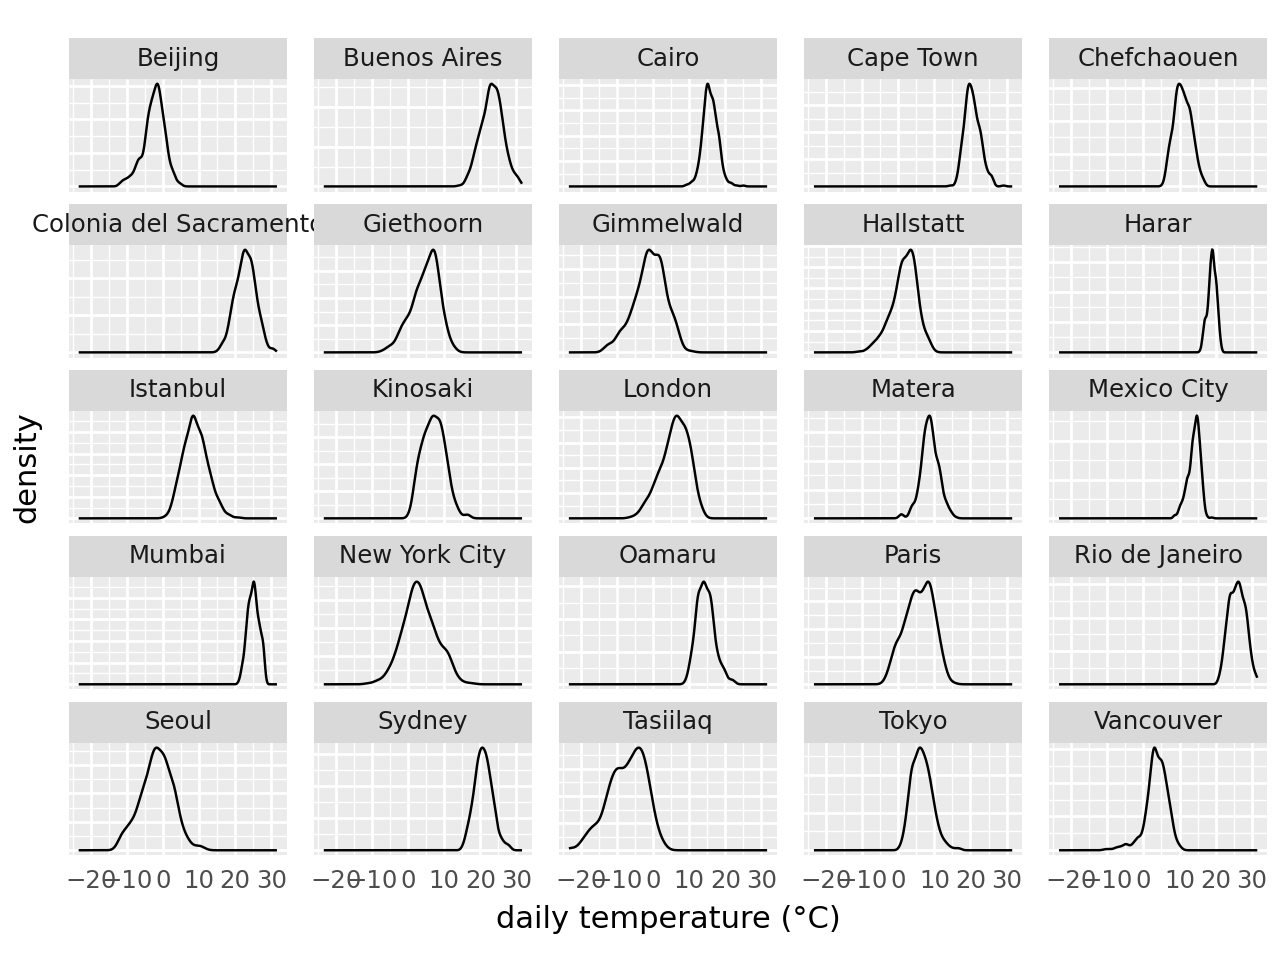

<Figure Size: (640 x 480)>

In [5]:
from plotnine import *

(
    ggplot(weather_df) + aes('temperature') +
    geom_density() +
    facet_wrap('~ city', scales='free_y', ncol=5) +
    xlab('daily temperature (°C)') +
    theme(axis_ticks=element_blank(), axis_text_y=element_blank())
)

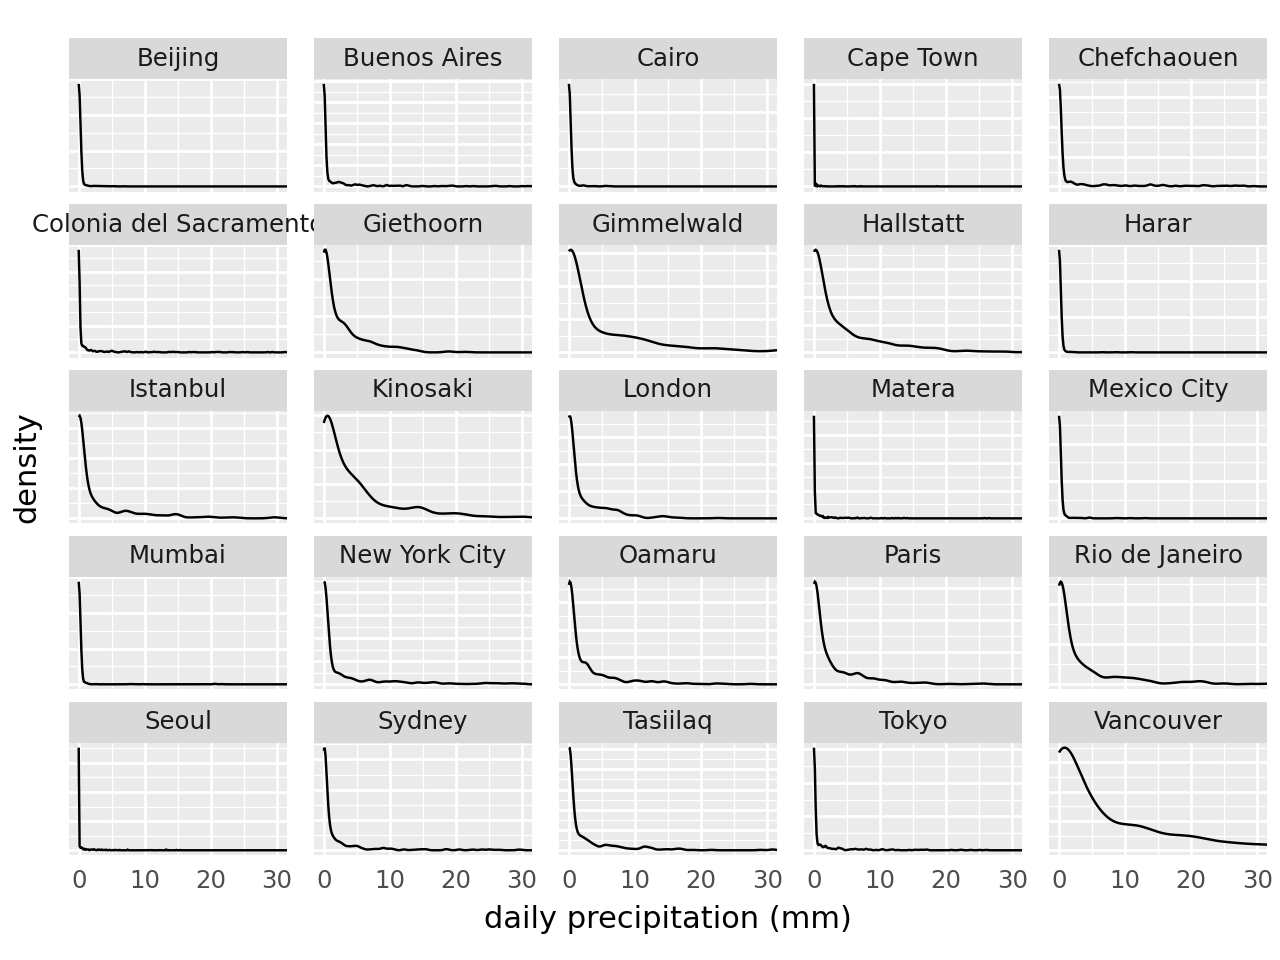

<Figure Size: (640 x 480)>

In [6]:
(
    ggplot(weather_df) + aes('precipitation') +
    geom_density() +
    facet_wrap('~ city', scales='free_y', ncol=5) +
    xlab('daily precipitation (mm)') +
    theme(axis_ticks=element_blank(), axis_text_y=element_blank()) +
    coord_cartesian(xlim=(0, 30))
)

In [7]:
weather_df.groupby('city').agg({'temperature': ['mean', 'std'], 'precipitation': ['mean', 'std']})# .loc['Beijing', ('temperature', 'mean')]

temperature           precipitation           
                              mean       std          mean        std
city                                                                 
Beijing                  -2.566573  2.960003      0.093318   0.565503
Buenos Aires             23.205585  3.009814      2.641475   7.352163
Cairo                    15.811659  2.076207      0.123733   0.596575
Cape Town                20.556415  2.150124      0.561751   2.085519
Chefchaouen              10.887376  2.325423      4.923963  14.096738
Colonia del Sacramento   22.825103  2.758331      2.754147   8.304304
Giethoorn                 4.755808  3.769420      2.558065   3.590428
Gimmelwald               -0.975768  4.359746      4.810138   7.588391
Hallstatt                 1.656864  3.500744      4.352765   7.074187
Harar                    19.015367  1.187028      0.091244   0.754213
Istanbul                  8.962699  3.341399      3.059217   5.661447
Kinosaki                  7.049760  3.084773      4.956221   7.052680
London                    5.951880  3.828945      2.103226   3.419924
Matera                    8.707401  2.455145      1.077880   4.430553
Mexico City              14.016931  1.696691      0.200000   1.108272
Mumbai                   25.021889  1.581925      0.387788   4.075932
New York City             3.249441  4.616397      3.607143   8.384293
Oamaru                   14.492893  2.445541      2.631106   4.806623
Paris                     5.711439  3.867121      2.551383   4.161665
Rio de Janeiro           25.997871  2.240033      3.847696   7.028721
Seoul                    -1.740958  4.403005      0.856452   2.999040
Sydney                   20.861307  2.423492      2.190553   4.929604
Tasiilaq                 -7.367795  5.078423      2.496774   5.423338
Tokyo                     6.531108  2.771244      2.092166   5.886700
Vancouver                 3.554076  3.113348      7.414977   9.947921

We can also plot the monthly total precipitation, but if daily precipitation is an exponential random variable, then the sum of (independent) daily precipitation would be distributed gamma. Not only is this less skewed, it gives us less data and there is no nice formula for the predictive distribution of a gamma prior for a gamma likelihood...

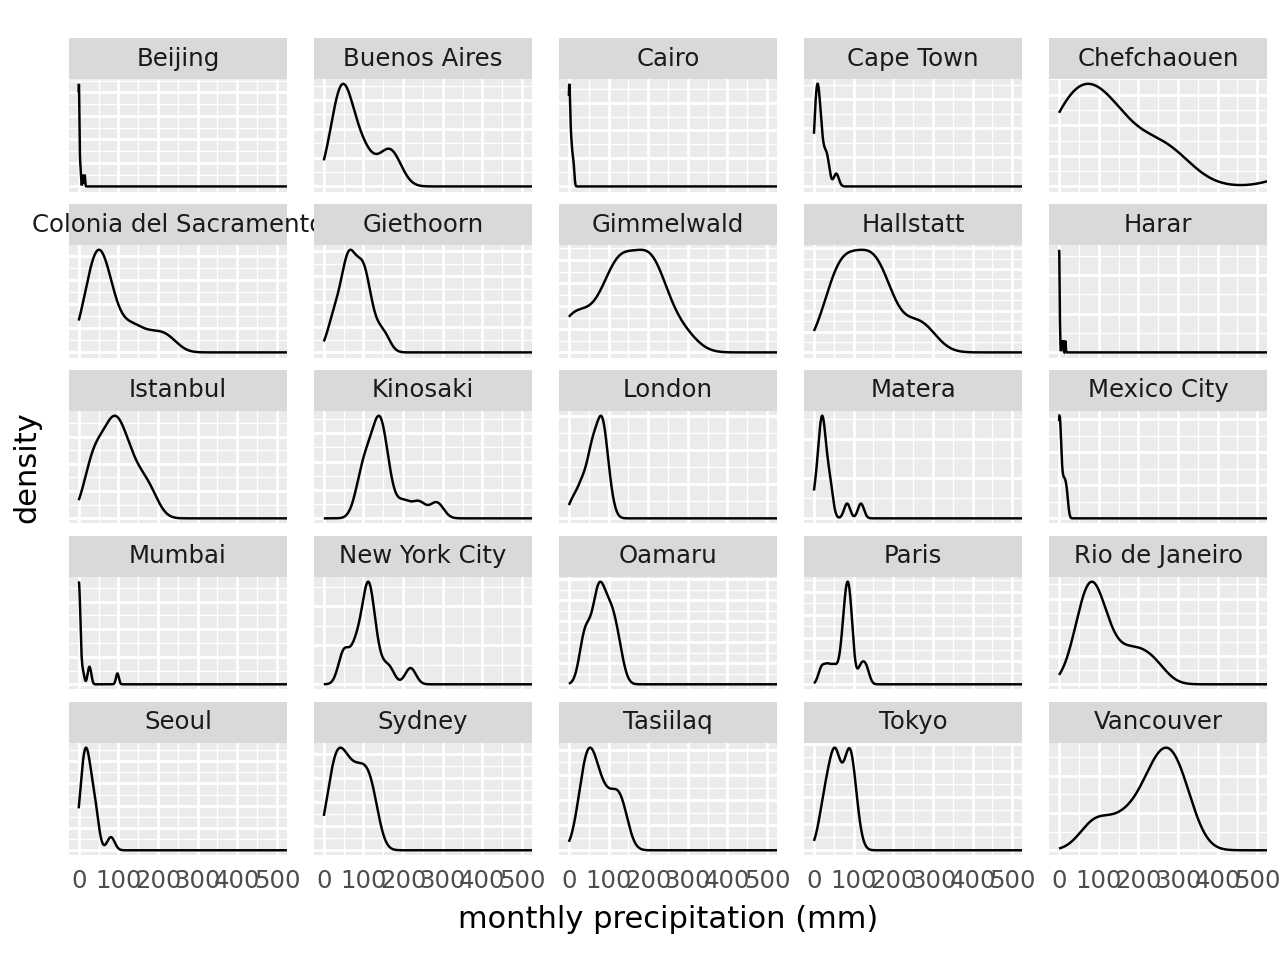

<Figure Size: (640 x 480)>

In [8]:
agg_dict = {
    'temperature': ['mean', 'std'],
    'precipitation': ['sum', 'std'],
    'latitude': 'first',
    'longitude': 'first'
}
weather_monthly = weather_df.groupby(
    ['city', weather_df.index.year]).agg(agg_dict)
weather_monthly.columns = [
    '_'.join(c) for c in weather_monthly.columns.to_flat_index()]  # tidying

(ggplot(weather_monthly.reset_index()) +
 aes('precipitation_sum') +
 geom_density() +
 xlab('monthly precipitation (mm)') +
 facet_wrap('~ city', scales='free_y', ncol=5) +
 theme(axis_ticks=element_blank(), axis_text_y=element_blank()) +
 coord_cartesian(xlim=(0, 500))
 )

## Plotting the priors

### Gamma distribution

We imposed the restriction that precipitation must have an exponential distribution and hence elicited a conjugate gamma prior distribution for the rate parameter $\theta$. Hence we're interested in daily precipitation in the month, not total precipitation.

In [9]:
priors_df[priors_df.target == 'precipitation'].head()

,index,field,target,dist,params,model,role,shelf,roulette,timestamp
25,25,Tokyo,precipitation,gamma,"{'shape': 2.5, 'scale': 0.5}",meta-llama/Llama-2-13b-chat-hf,expert,False,False,2024-02-08 18:24:38
26,26,New York City,precipitation,gamma,"{'shape': 2.5, 'scale': 0.5}",meta-llama/Llama-2-13b-chat-hf,expert,False,False,2024-02-08 18:24:38
27,27,London,precipitation,gamma,"{'shape': 2.5, 'scale': 0.5}",meta-llama/Llama-2-13b-chat-hf,expert,False,False,2024-02-08 18:24:38
28,28,Sydney,precipitation,gamma,"{'shape': 2.5, 'scale': 0.5}",meta-llama/Llama-2-13b-chat-hf,expert,False,False,2024-02-08 18:24:38
29,29,Cape Town,precipitation,gamma,"{'shape': 2.5, 'scale': 0.5}",meta-llama/Llama-2-13b-chat-hf,expert,False,False,2024-02-08 18:24:38


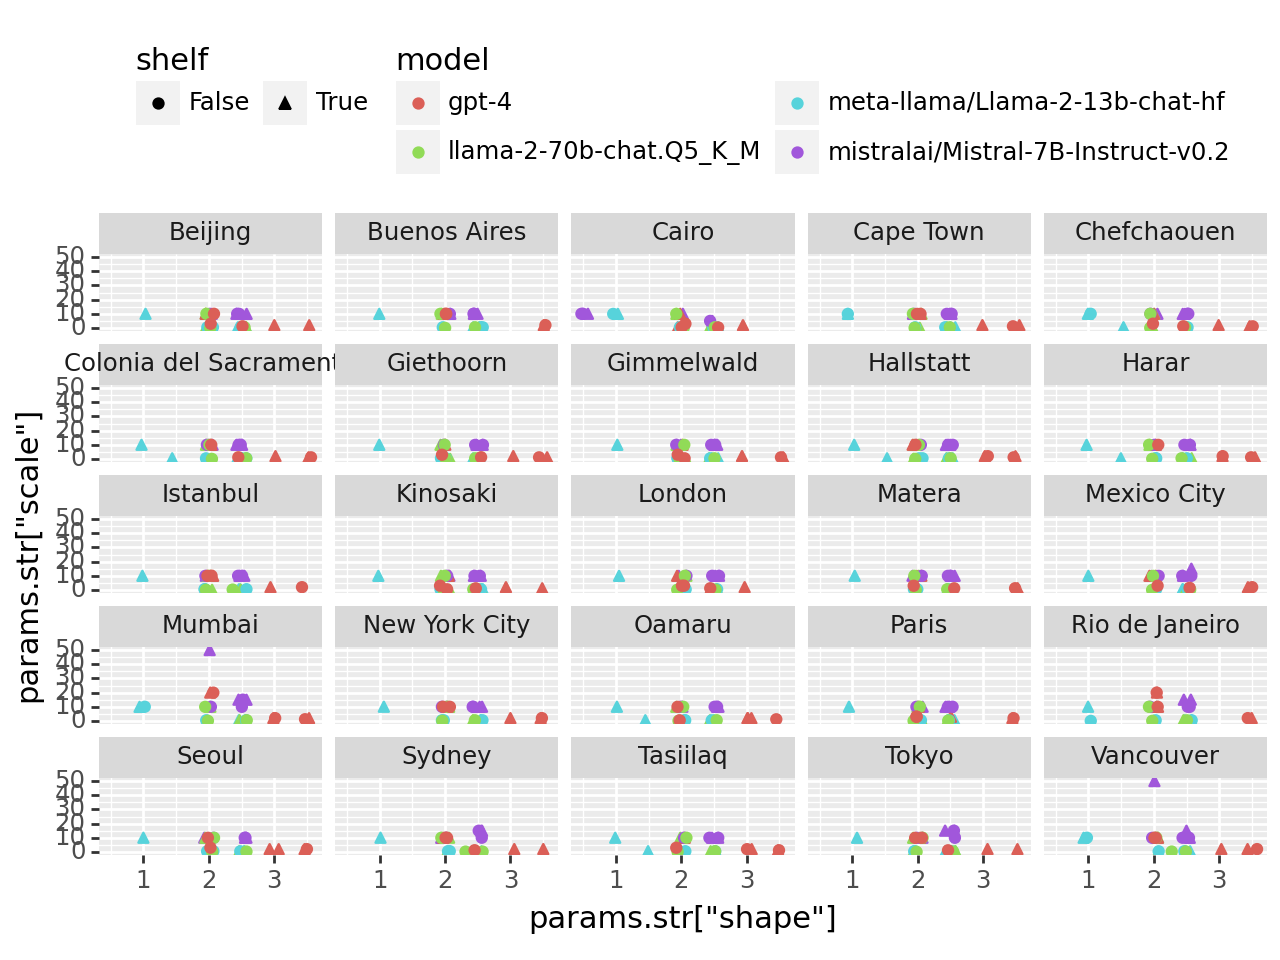

<Figure Size: (640 x 480)>

In [10]:
(
    ggplot(priors_df[priors_df.target == 'precipitation']) +
    aes('params.str["shape"]', 'params.str["scale"]', shape='shelf', colour='model') +
    geom_jitter() +
    # geom_text(aes(label='field')) +
    facet_wrap('~field', ncol=5) +
    theme(legend_position='top') +
    guides(colour=guide_legend(nrow=2))
)

In [ ]:
from scipy.stats import gamma
import numpy as np

x_values = np.linspace(0, 50, 200)
pdf_df = pd.DataFrame()
for index, row in priors_df.iterrows():
    if row.dist == 'gamma':
        shape = row.params['shape']
        scale = row.params['scale']
        pdf_values = gamma.pdf(x_values, shape, scale=scale)
        pdf_df = pd.concat([pdf_df, pd.DataFrame({'x': x_values, 'y': pdf_values, 'id': index,
                                                  'model': row.model, 'role': row.role,
                                                  'shelf': row.shelf, 'roulette': row.roulette})])

(
    ggplot(pdf_df)
    + aes('x', 'y', fill='role', group='id')
    + geom_area(position='stack')
    + facet_grid('role + shelf ~ model', scales='free_y')
)

### Normal-inverse-gamma distribution

Plotting the density of a normal-inverse-gamma distribution is not so easy, because it is a multivariate distribution. Let's look at the means and the scales/precision for now.

In [13]:
priors_df.head()

,index,field,target,dist,params,model,role,shelf,roulette,timestamp
0,0,Tokyo,temperature,normal_inverse_gamma,"{'mean': 12.0, 'precision': 2.5, 'shape': 2.0,...",meta-llama/Llama-2-13b-chat-hf,expert,False,False,2024-02-08 18:24:38
1,1,New York City,temperature,normal_inverse_gamma,"{'mean': 4.5, 'precision': 0.5, 'shape': 2.5, ...",meta-llama/Llama-2-13b-chat-hf,expert,False,False,2024-02-08 18:24:38
2,2,London,temperature,normal_inverse_gamma,"{'mean': 8.5, 'precision': 1.5, 'shape': 2.5, ...",meta-llama/Llama-2-13b-chat-hf,expert,False,False,2024-02-08 18:24:38
3,3,Sydney,temperature,normal_inverse_gamma,"{'mean': 14.5, 'precision': 2.5, 'shape': 2.0,...",meta-llama/Llama-2-13b-chat-hf,expert,False,False,2024-02-08 18:24:38
4,4,Cape Town,temperature,normal_inverse_gamma,"{'mean': 18.5, 'precision': 2.5, 'shape': 2.0,...",meta-llama/Llama-2-13b-chat-hf,expert,False,False,2024-02-08 18:24:38


In [14]:
(
    ggplot(priors_df[(priors_df.target == 'temperature')]) +
    aes('params.mean', 'params.precision', shape='shelf', colour='model') +
    geom_jitter() +
    # geom_text(aes(label='field')) +
    facet_wrap('~field', ncol=5) +
    scale_y_log10() +
    theme(legend_position='top')
)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/david/quantllm/.venv/lib/python3.10/site-packages/plotnine/mapping/evaluation.py", line 228, in evaluate
    new_val = env.eval(col, inner_namespace=data)
  File "/home/david/quantllm/.venv/lib/python3.10/site-packages/patsy/eval.py", line 169, in eval
    return eval(code, {}, VarLookupDict([inner_namespace]
  File "<string>", line 1, in <module>
  File "/home/david/quantllm/.venv/lib/python3.10/site-packages/pandas/core/generic.py", line 6293, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'Series' object has no attribute 'precision'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/david/quantllm/.venv/lib/python3.10/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "/home/david/quantllm/.venv/lib/python3.10/site-packages/IPython/core/formatters.py", line 708, in __ca

# Prior effective sample size

For a $\text{Gamma}(\alpha_0, \beta_0)$ prior, the prior effective sample size is $\alpha_0$, i.e. the shape hyperparameter.

For a $\text{Normal-Inverse-Gamma}(\mu_0, \lambda_0, \alpha_0, \beta_0)$ prior, where $\lambda_0$ denotes precision, the prior effective sample size is, supposedly, the reciprocal of the prior variance, i.e. $\lambda_0$.

In [15]:
priors_df2 = pd.concat([priors_df, pd.json_normalize(priors_df.params)], axis=1)
priors_df2.head()

,index,field,target,dist,params,model,role,shelf,roulette,timestamp,mean,precision,shape,scale
0,0,Tokyo,temperature,normal_inverse_gamma,"{'mean': 12.0, 'precision': 2.5, 'shape': 2.0,...",meta-llama/Llama-2-13b-chat-hf,expert,False,False,2024-02-08 18:24:38,12.0,2.5,2.0,0.5
1,1,New York City,temperature,normal_inverse_gamma,"{'mean': 4.5, 'precision': 0.5, 'shape': 2.5, ...",meta-llama/Llama-2-13b-chat-hf,expert,False,False,2024-02-08 18:24:38,4.5,0.5,2.5,1.5
2,2,London,temperature,normal_inverse_gamma,"{'mean': 8.5, 'precision': 1.5, 'shape': 2.5, ...",meta-llama/Llama-2-13b-chat-hf,expert,False,False,2024-02-08 18:24:38,8.5,1.5,2.5,0.5
3,3,Sydney,temperature,normal_inverse_gamma,"{'mean': 14.5, 'precision': 2.5, 'shape': 2.0,...",meta-llama/Llama-2-13b-chat-hf,expert,False,False,2024-02-08 18:24:38,14.5,2.5,2.0,0.5
4,4,Cape Town,temperature,normal_inverse_gamma,"{'mean': 18.5, 'precision': 2.5, 'shape': 2.0,...",meta-llama/Llama-2-13b-chat-hf,expert,False,False,2024-02-08 18:24:38,18.5,2.5,2.0,0.5


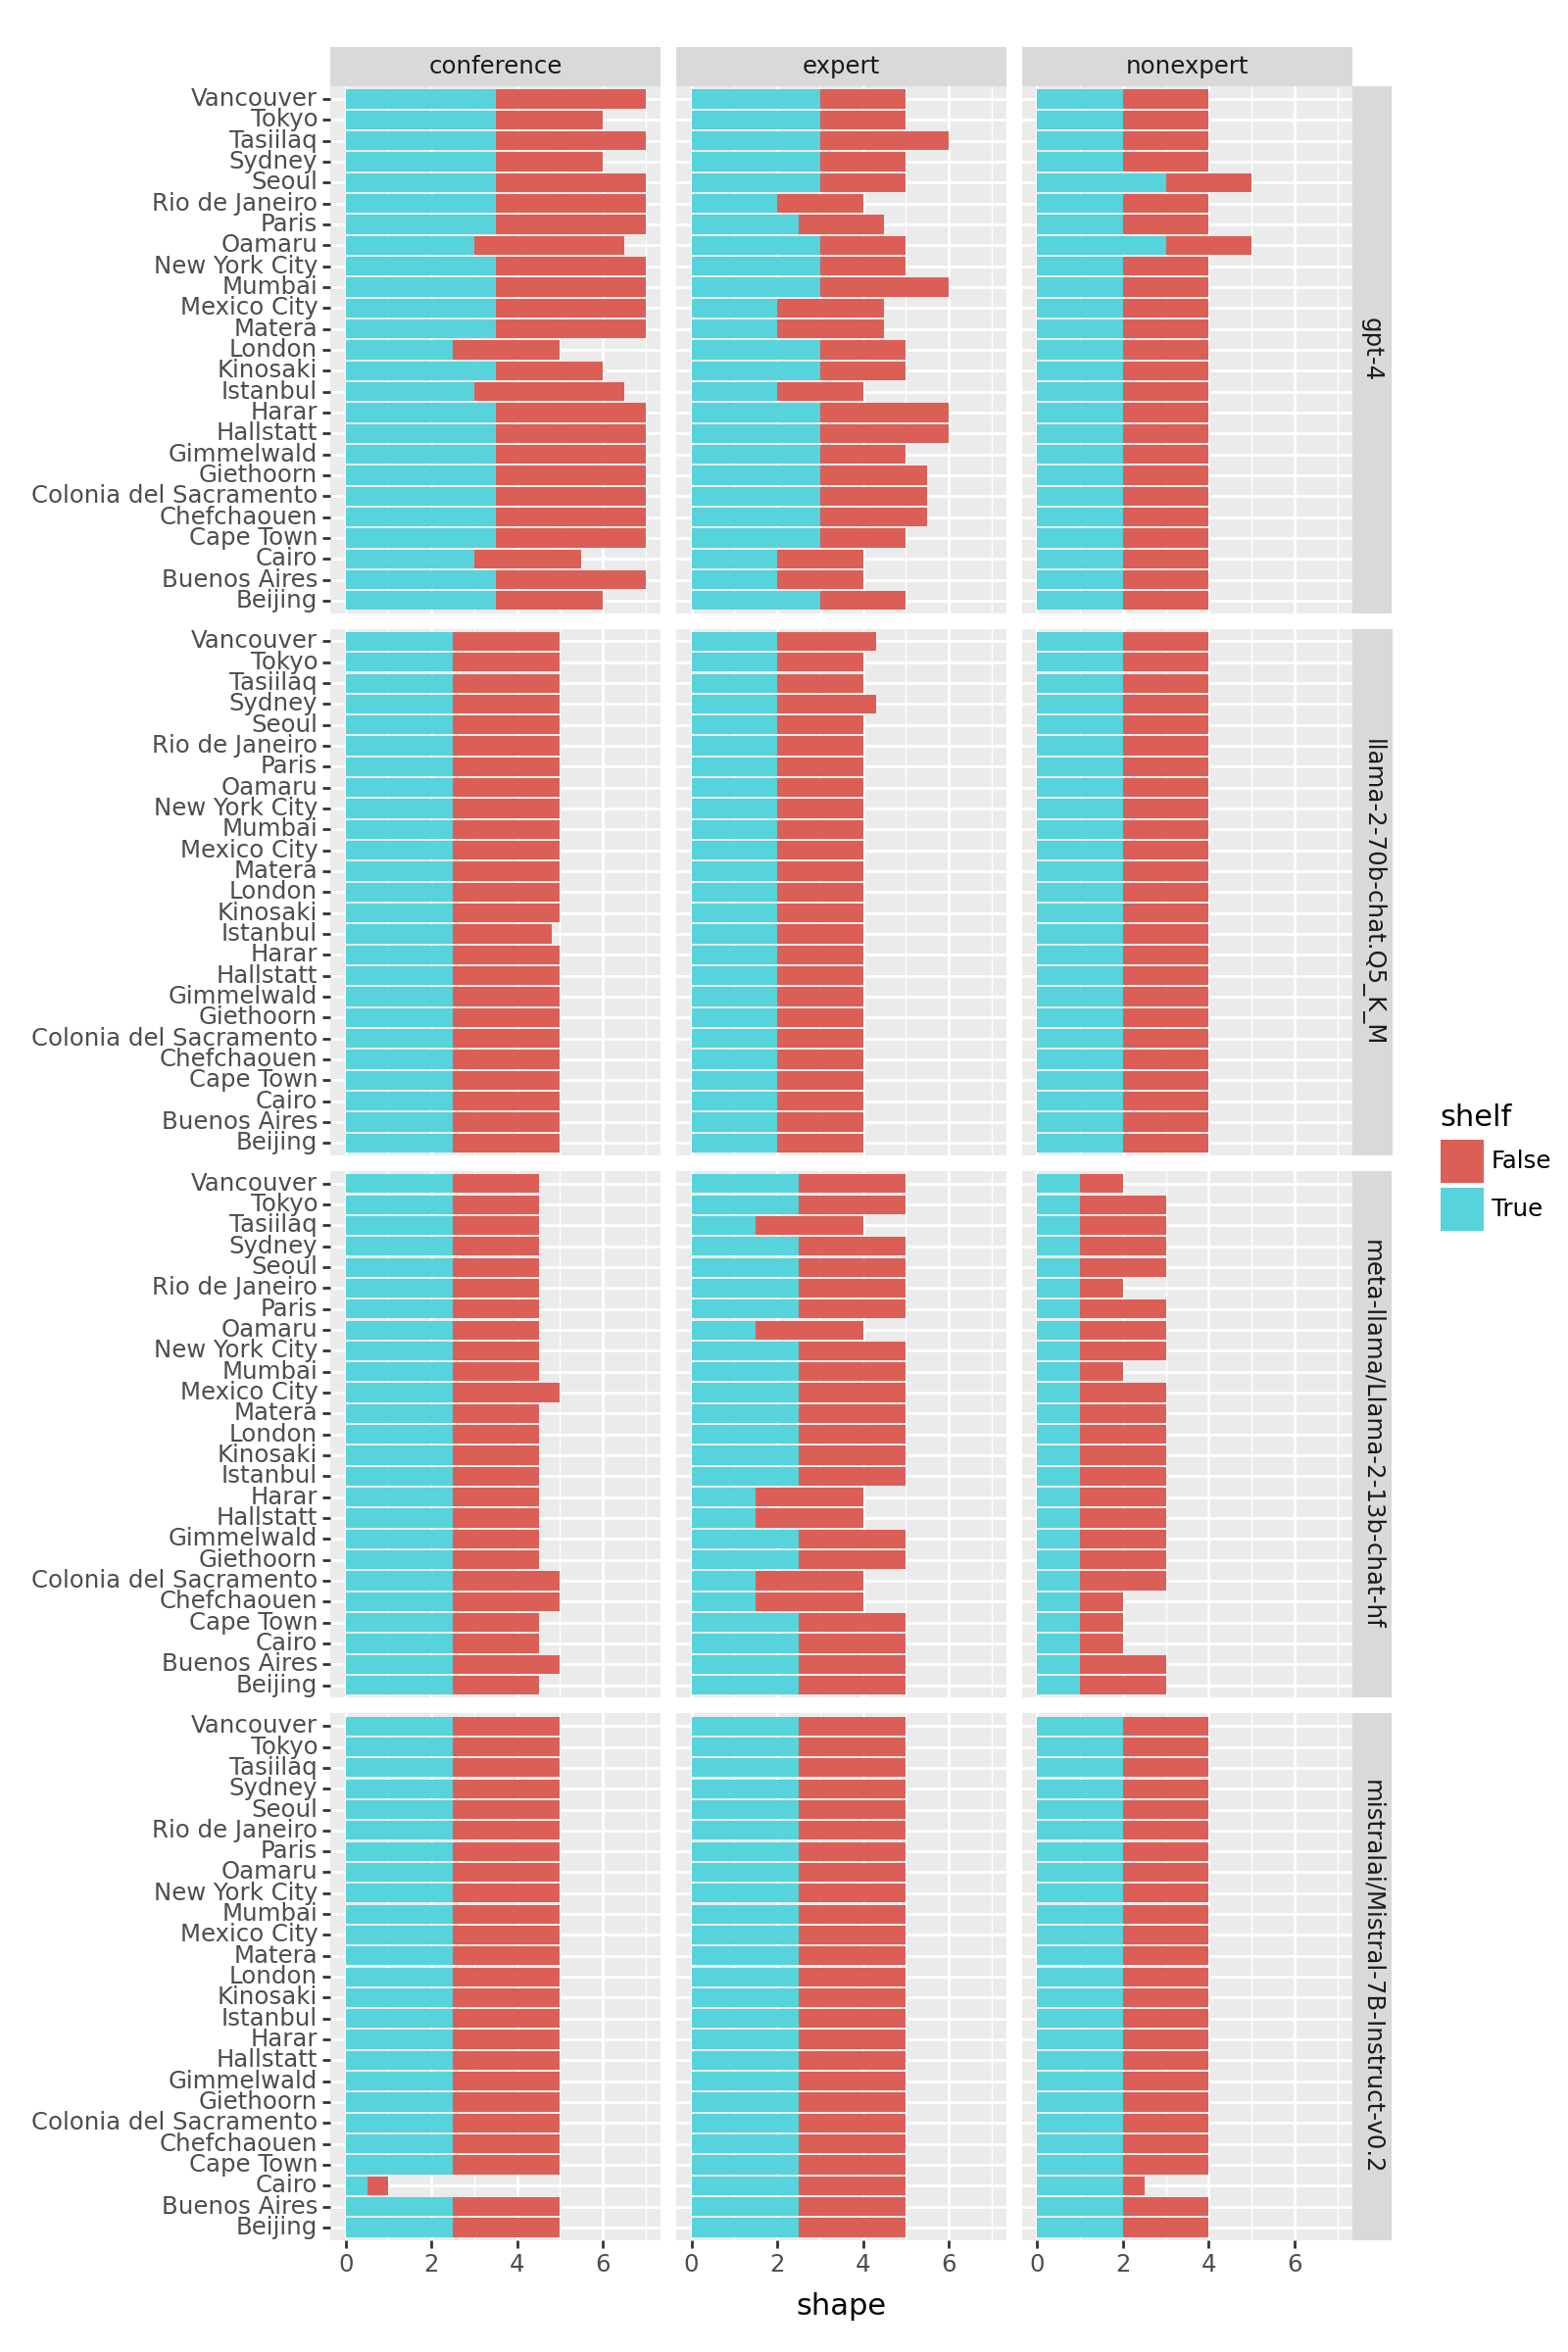

<Figure Size: (800 x 1200)>

In [16]:
# For gammas only

(
    ggplot(priors_df2[(priors_df2.dist == 'gamma') & (~priors_df2.roulette)]) +
    aes(x='field', y='shape', fill='shelf') +
    geom_col() +
    facet_grid('model ~ role') +
    coord_flip() +
    theme(figure_size = (8, 12)) +
    labs(x = '')
)

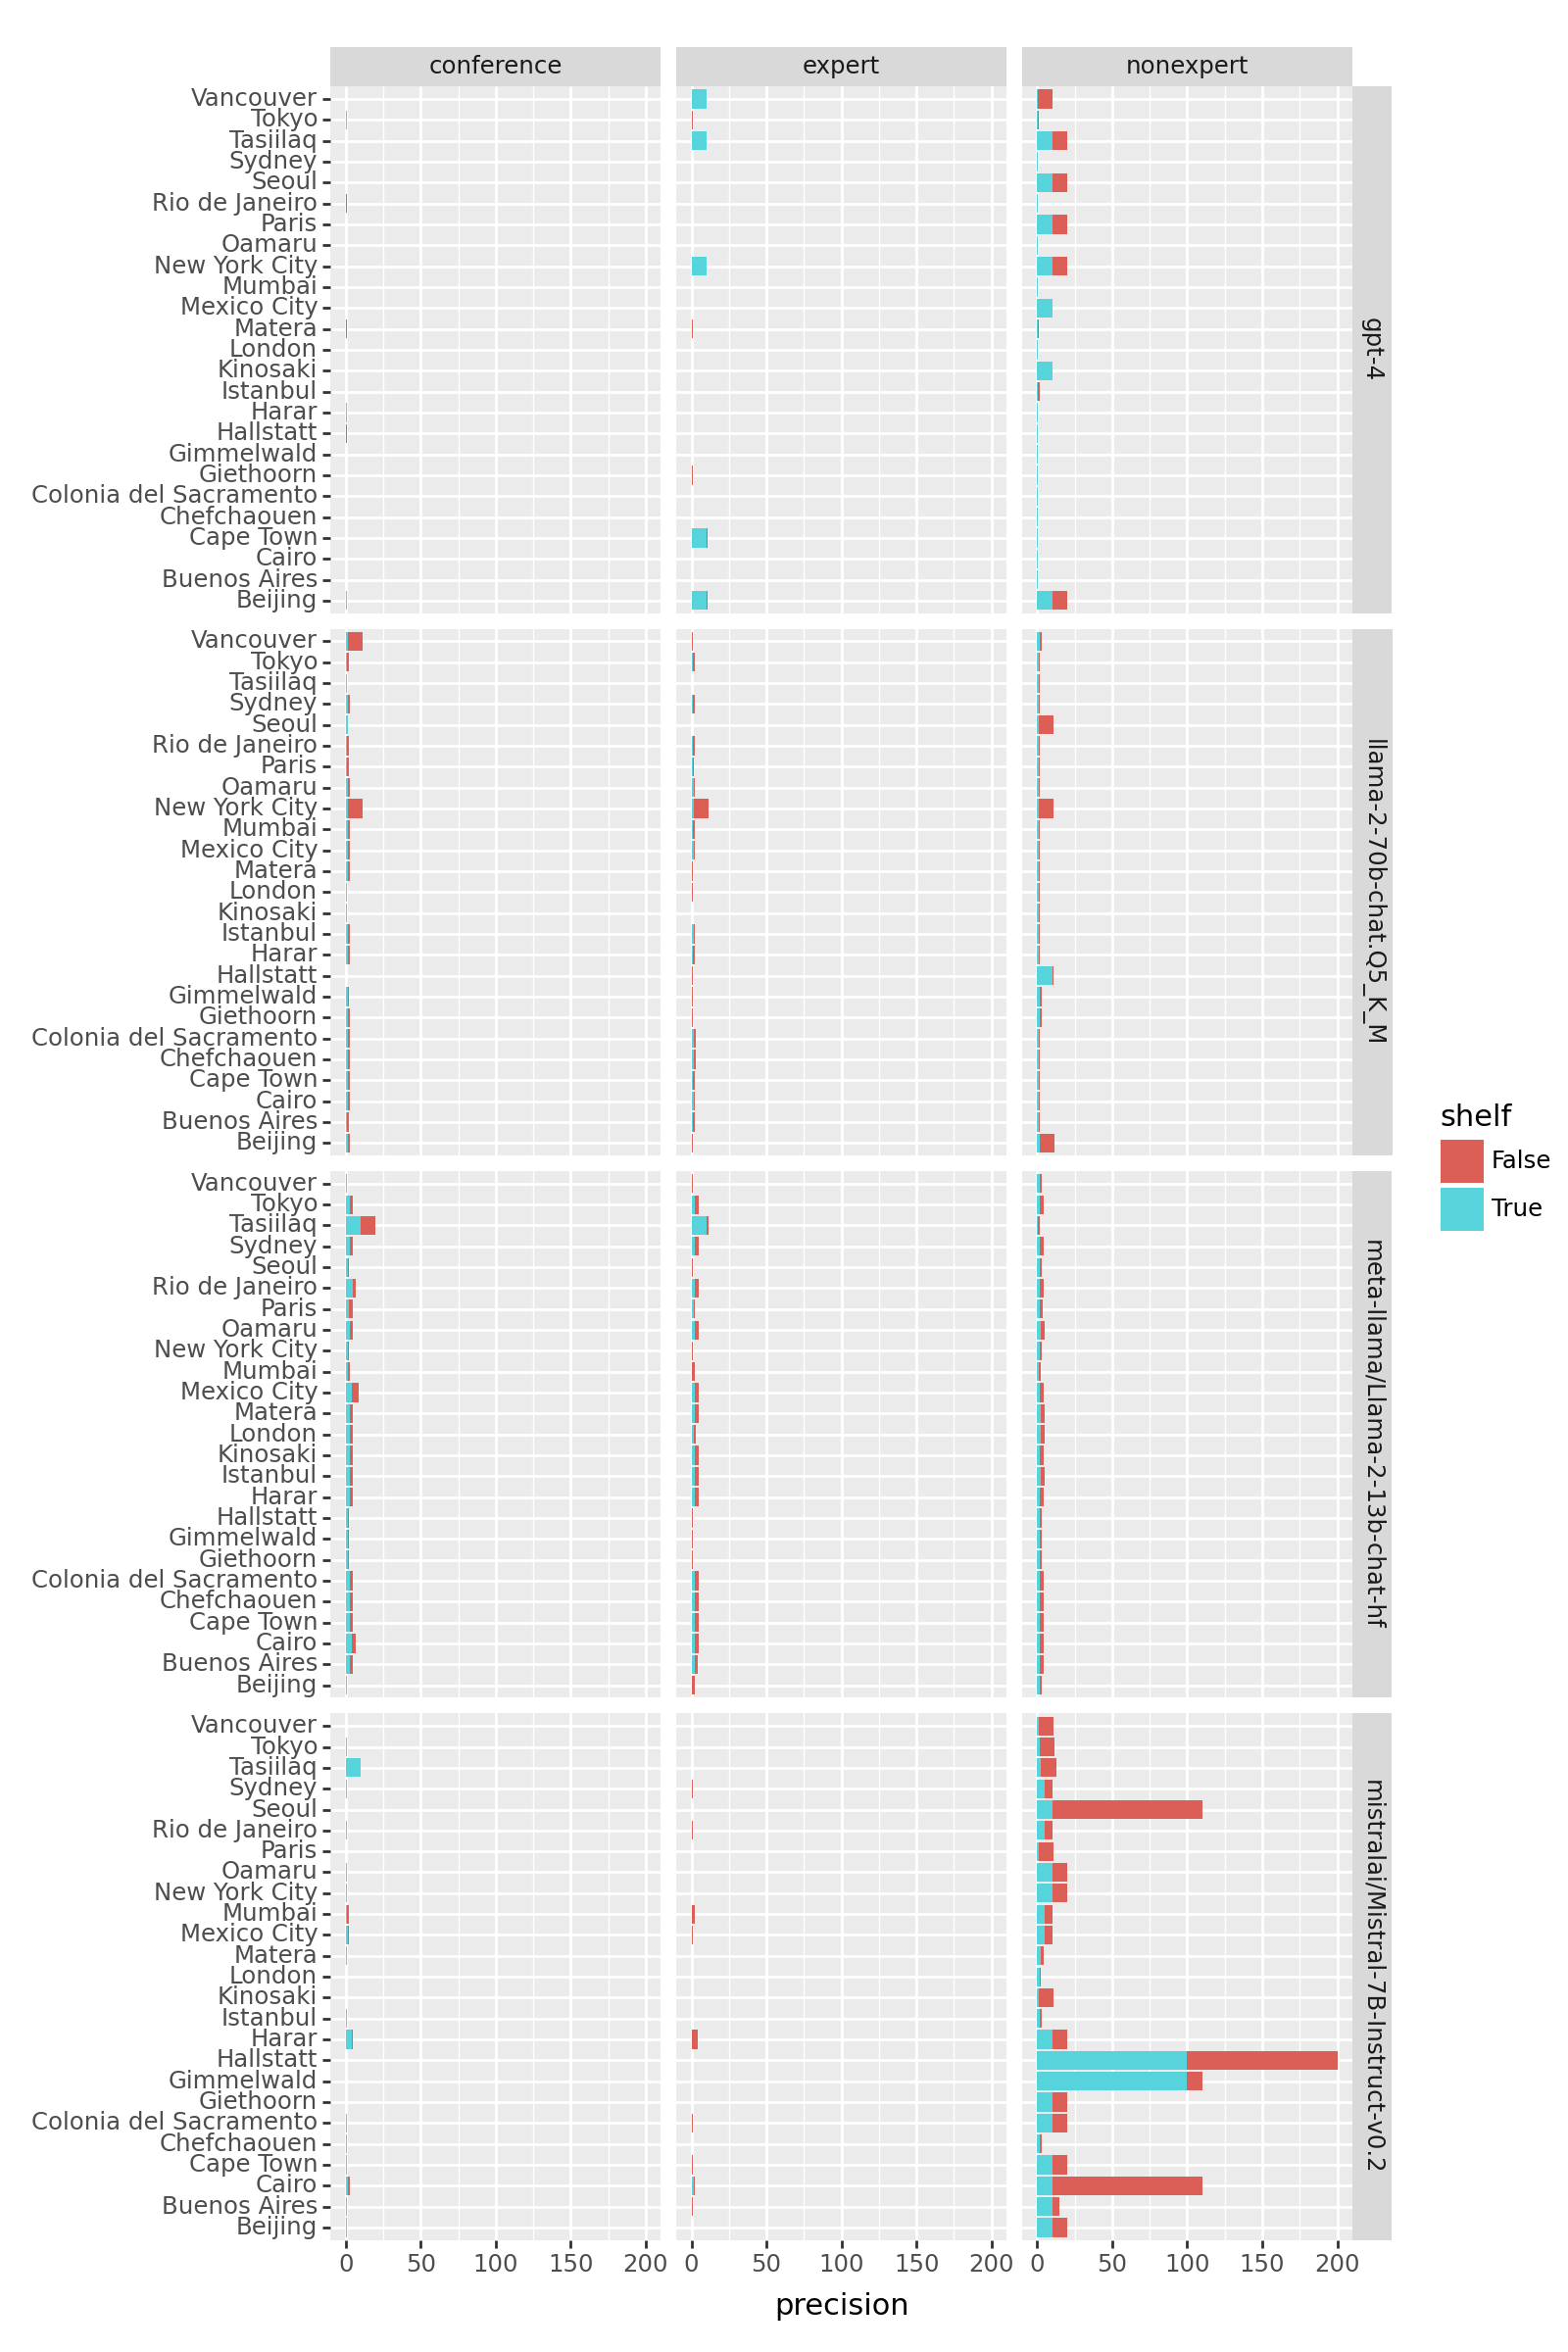

<Figure Size: (800 x 1200)>

In [17]:
# For gammas only

(
    ggplot(priors_df2[(priors_df2.dist == 'normal_inverse_gamma') & (~priors_df2.roulette)]) +
    aes(x='field', y='precision', fill='shelf') +
    geom_col() +
    facet_grid('model ~ role') +
    coord_flip() +
    theme(figure_size = (8, 12)) +
    labs(x = '')
)

In [18]:
priors_df2[(~priors_df.roulette) & (priors_df.dist == 'gamma')].groupby(['model', 'role', 'shelf']).shape.agg(['mean', 'std']).reset_index().sort_values(by = 'mean')

,model,role,shelf,mean,std
17,meta-llama/Llama-2-13b-chat-hf,nonexpert,True,1.000,0.000000
16,meta-llama/Llama-2-13b-chat-hf,nonexpert,False,1.760,0.435890
22,mistralai/Mistral-7B-Instruct-v0.2,nonexpert,False,1.940,0.300000
11,llama-2-70b-chat.Q5_K_M,nonexpert,True,2.000,0.000000
10,llama-2-70b-chat.Q5_K_M,nonexpert,False,2.000,0.000000
9,llama-2-70b-chat.Q5_K_M,expert,True,2.000,0.000000
23,mistralai/Mistral-7B-Instruct-v0.2,nonexpert,True,2.000,0.000000
4,gpt-4,nonexpert,False,2.000,0.000000
8,llama-2-70b-chat.Q5_K_M,expert,False,2.024,0.083066
5,gpt-4,nonexpert,True,2.080,0.276887


/home/david/quantllm/.venv/lib/python3.10/site-packages/plotnine/scales/scale_size.py:49: PlotnineWarning: Using size for a discrete variable is not advised.


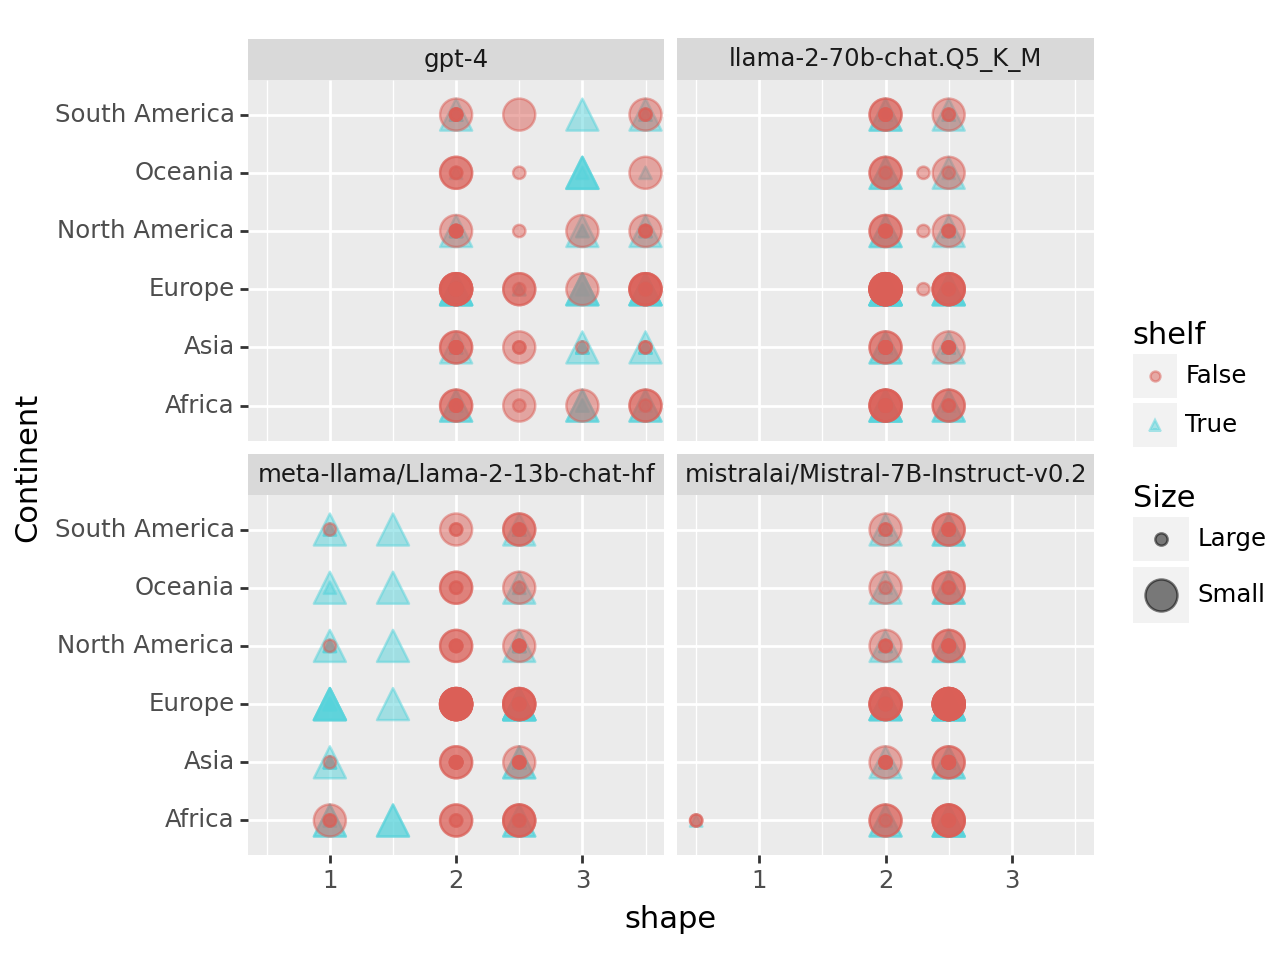

<Figure Size: (640 x 480)>

In [19]:
x = priors_df2.merge(city_info, left_on='field', right_on='City')
x.Continent = x.Continent.replace('Europe/Asia', 'Europe')

(
    ggplot(x[x.dist=='gamma']) +
    aes('Continent', 'shape') +
    geom_point(aes(shape='shelf', size='Size', colour='shelf'), alpha=.5) +
    facet_wrap('~model') +
    coord_flip()
)

# CRPS

In [20]:
priors_df

,index,field,target,dist,params,model,role,shelf,roulette,timestamp
0,0,Tokyo,temperature,normal_inverse_gamma,"{'mean': 12.0, 'precision': 2.5, 'shape': 2.0,...",meta-llama/Llama-2-13b-chat-hf,expert,False,False,2024-02-08 18:24:38
1,1,New York City,temperature,normal_inverse_gamma,"{'mean': 4.5, 'precision': 0.5, 'shape': 2.5, ...",meta-llama/Llama-2-13b-chat-hf,expert,False,False,2024-02-08 18:24:38
2,2,London,temperature,normal_inverse_gamma,"{'mean': 8.5, 'precision': 1.5, 'shape': 2.5, ...",meta-llama/Llama-2-13b-chat-hf,expert,False,False,2024-02-08 18:24:38
3,3,Sydney,temperature,normal_inverse_gamma,"{'mean': 14.5, 'precision': 2.5, 'shape': 2.0,...",meta-llama/Llama-2-13b-chat-hf,expert,False,False,2024-02-08 18:24:38
4,4,Cape Town,temperature,normal_inverse_gamma,"{'mean': 18.5, 'precision': 2.5, 'shape': 2.0,...",meta-llama/Llama-2-13b-chat-hf,expert,False,False,2024-02-08 18:24:38
...,...,...,...,...,...,...,...,...,...,...
1195,45,Istanbul,precipitation,gamma,"{'shape': 3.0, 'scale': 2.0}",gpt-4,conference,True,False,2024-02-08 20:36:45
1196,46,Vancouver,precipitation,gamma,"{'shape': 3.5, 'scale': 2.0}",gpt-4,conference,True,False,2024-02-08 20:36:45
1197,47,Cairo,precipitation,gamma,"{'shape': 3.0, 'scale': 2.0}",gpt-4,conference,True,False,2024-02-08 20:36:45
1198,48,Buenos Aires,precipitation,gamma,"{'shape': 3.5, 'scale': 2.0}",gpt-4,conference,True,False,2024-02-08 20:36:45


In [21]:
weather_df

,temperature,precipitation,city,address,latitude,longitude
date,,,,,,
2010-12-01,10.069083,0.000000,Tokyo,"東京都, 日本",35.682194,139.762221
2010-12-02,13.787833,44.100002,Tokyo,"東京都, 日本",35.682194,139.762221
2010-12-03,13.273248,0.400000,Tokyo,"東京都, 日本",35.682194,139.762221
2010-12-04,9.221168,0.000000,Tokyo,"東京都, 日本",35.682194,139.762221
2010-12-05,9.531584,0.000000,Tokyo,"東京都, 日本",35.682194,139.762221
...,...,...,...,...,...,...
2023-12-27,0.345667,0.000000,Seoul,"서울특별시, 대한민국",37.566679,126.978291
2023-12-28,0.141500,0.000000,Seoul,"서울특별시, 대한민국",37.566679,126.978291
2023-12-29,-0.002250,0.000000,Seoul,"서울특별시, 대한민국",37.566679,126.978291


In [50]:
def find_first_index_below_threshold(arr, threshold):
    """
    Finds the first index where all values in the array are smaller than the given threshold.

    Args:
        arr (numpy.ndarray): Input array.
        threshold (float): Threshold value.

    Returns:
        int: Index of the first segment where all values are below the threshold.
        Returns -1 if no such segment exists.
    """
    for i in range(len(arr)):
        segment = arr[i:]
        if np.all(segment < threshold):
            return i
    return -1

find_first_index_below_threshold(np.array([5, 6, 7, 3, 5, 3, 2, 2]), 4)
find_first_index_below_threshold(-np.array([5, 6, 7, 3, 5, 3, 5, 5]), -4)

6

In [73]:
import properscoring as ps
from scipy import stats

def evaluate_freq_norm(train, test, method='crps', debug=False):
    scores = []
    for n in range(2, len(train) + 1):
        segment = train[:n]
        mu, sig = segment.mean(), np.std(segment, ddof=1)
        #model = stats.norm(loc=mu, scale=sig) # could also do stats.t
        if method=='crps':
            if debug:
                print(f'Scoring {n}')
            score = ps.crps_gaussian(test, mu=mu, sig=sig).mean()
            scores.append(score)
        elif method=='mse':
            if debug:
                print(f'MSE {n}')
            score = np.mean((test - mu) ** 2)
            scores.append(score)
        else:
            raise NotImplementedError(f'No scoring method {method}')
    return scores

In [77]:
from modules.conjugate import GammaExponentialPrior, NormalInverseGammaPrior
import properscoring as ps
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# ps.crps_quadrature
# ps.crps_ensemble

K = 20 # number of replicates
n = 100 # number of sub-samples

ess_mse_list = []
ess_crps_list = []
nig_priors = priors_df[priors_df.dist=='normal_inverse_gamma'].reset_index()
for i, prior_i in tqdm(nig_priors.iterrows(), total=len(nig_priors), desc="Computing CRPS"):
    # Get the prior distribution.
    params = prior_i.params
    if 'precision' in params:
        params['variance'] = 1 / params.pop('precision')
    model = GammaExponentialPrior(**params) if prior_i.dist == 'gamma' else NormalInverseGammaPrior(**params)
    # Get the data.
    observations = weather_df[weather_df.city == prior_i.field][prior_i.target]
    train, test = train_test_split(observations, test_size=100)
    # Get the prior predictive score.
    prior_crps = np.inf
    try:
        prior_crps = np.inf#ps.crps_quadrature(test, model.prior_pred).mean()
    except Exception as e:
        print(f'Failed to compute CRPS for row {i}:\n{e}')
    prior_mse = np.mean((model.prior_pred.mean() - test)**2)
    # ensmbl = model.prior_pred.rvs(1000)
    # prior_score = np.mean([ps.crps_ensemble(x, ensmbl) for x in test])
    # Initialize list for frequentist analysis.
    freq_crps = np.zeros(n-1)
    freq_mse = np.zeros(n-1)
    for _ in range(K):
        # Sample 100 trainingx points
        smpl = np.random.choice(test, size=n, replace=False)
        #freq_crps += evaluate_freq_norm(smpl, test, 'crps') # returns vector of length n-1
        freq_mse += evaluate_freq_norm(smpl, test, 'mse')
    freq_crps /= K # mean
    freq_mse /= K
    # A lower CRPS is better!
    ess_crps = find_first_index_below_threshold(freq_crps, prior_crps)
    ess_mse  = find_first_index_below_threshold(freq_mse, prior_mse)
    ess_crps_list += [ess_crps]
    ess_mse_list += [ess_mse]

#nig_priors['ess_crps'] = ess_crps_list
nig_priors['ess_mse'] = ess_mse_list

Computing CRPS:  57%|█████▋    | 340/600 [01:43<01:18,  3.31it/s]/home/david/quantllm/scripts/elicitation/modules/conjugate.py:12: RuntimeWarning: divide by zero encountered in scalar divide
/home/david/quantllm/.venv/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1135: RuntimeWarning: invalid value encountered in multiply
Computing CRPS: 100%|██████████| 600/600 [03:01<00:00,  3.30it/s]
/tmp/ipykernel_29301/1690719323.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [79]:
ess_mse_list

[0,
 5,
 1,
 0,
 0,
 10,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 18,
 1,
 4,
 0,
 39,
 0,
 11,
 5,
 15,
 0,
 0,
 0,
 12,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 2,
 10,
 0,
 0,
 0,
 58,
 0,
 6,
 5,
 0,
 0,
 0,
 0,
 5,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 5,
 0,
 2,
 0,
 88,
 0,
 0,
 22,
 0,
 0,
 0,
 0,
 19,
 2,
 0,
 0,
 7,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 -1,
 0,
 3,
 0,
 98,
 0,
 1,
 7,
 16,
 0,
 0,
 0,
 4,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 98,
 0,
 12,
 8,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 10,
 0,
 91,
 0,
 0,
 9,
 0,
 0,
 0,
 4,
 0,
 11,
 11,
 0,
 7,
 0,
 0,
 11,
 1,
 11,
 0,
 29,
 13,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 4,
 0,
 2,
 0,
 2,
 20,
 0,
 13,
 3,
 0,
 0,
 10,
 0,
 1,
 0,
 15,
 6,
 4,
 0,
 1,
 0,
 0,
 1,
 0,
 2,
 5,
 0,
 5,
 0,
 2,
 48,
 14,
 47,
 12,
 0,
 0,
 11,
 3,
 0,
 0,
 8,
 18,
 8,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 8,
 0,
 1,
 7,
 1,
 11,
 2,
 16,
 3,
 0,
 0,
 5,
 5,
 0,
 0,
 30,
 35,
 0,
 0

In [80]:
nig_priors.to_csv('nig_priors.csv')

In [92]:
ess_mse_list2 = []
ess_crps_list2 = []
gam_priors = priors_df[priors_df.dist=='gamma'].reset_index()
for i, prior_i in tqdm(gam_priors.iterrows(), total=len(gam_priors), desc="Computing CRPS"):
    # Get the prior distribution.
    params = prior_i.params
    if 'precision' in params:
        params['variance'] = 1 / params.pop('precision')
    model = GammaExponentialPrior(**params) if prior_i.dist == 'gamma' else NormalInverseGammaPrior(**params)
    # Get the data.
    observations = weather_df[weather_df.city == prior_i.field][prior_i.target]
    train, test = train_test_split(observations, test_size=100)
    # Get the prior predictive score.
    prior_crps = np.inf
    try:
        prior_crps = np.inf#ps.crps_quadrature(test, model.prior_pred).mean()
    except Exception as e:
        print(f'Failed to compute CRPS for row {i}:\n{e}')
    prior_mse = np.mean((model.prior_pred.mean() - test)**2)
    # ensmbl = model.prior_pred.rvs(1000)
    # prior_score = np.mean([ps.crps_ensemble(x, ensmbl) for x in test])
    # Initialize list for frequentist analysis.
    freq_crps = np.zeros(n-1)
    freq_mse = np.zeros(n-1)
    for _ in range(K):
        # Sample 100 trainingx points
        smpl = np.random.choice(test, size=n, replace=False)
        freq_crps += evaluate_freq_norm(smpl, test, 'crps') # returns vector of length n-1
        freq_mse += evaluate_freq_norm(smpl, test, 'mse')
    freq_crps /= K # mean
    freq_mse /= K
    # A lower CRPS is better!
    ess_crps = find_first_index_below_threshold(freq_crps, prior_crps)
    ess_mse  = find_first_index_below_threshold(freq_mse, prior_mse)
    ess_crps_list2 += [ess_crps]
    ess_mse_list2 += [ess_mse]

#gam_priors['ess_crps'] = ess_crps_list2
gam_priors['ess_mse'] = ess_mse_list2

Computing CRPS:   0%|          | 0/600 [00:00<?, ?it/s]/home/david/quantllm/.venv/lib/python3.10/site-packages/properscoring/_crps.py:66: RuntimeWarning: divide by zero encountered in divide
/home/david/quantllm/.venv/lib/python3.10/site-packages/properscoring/_crps.py:66: RuntimeWarning: invalid value encountered in divide
/home/david/quantllm/.venv/lib/python3.10/site-packages/properscoring/_crps.py:72: RuntimeWarning: invalid value encountered in multiply
Computing CRPS: 100%|██████████| 600/600 [04:34<00:00,  2.19it/s]


In [93]:
gam_priors.to_csv('gam_priors.csv')

In [71]:
try:
    ps.crps_quadrature(test, NormalInverseGammaPrior(**nig_priors.iloc[89].params).prior_pred)
except Exception as e:
    np.inf

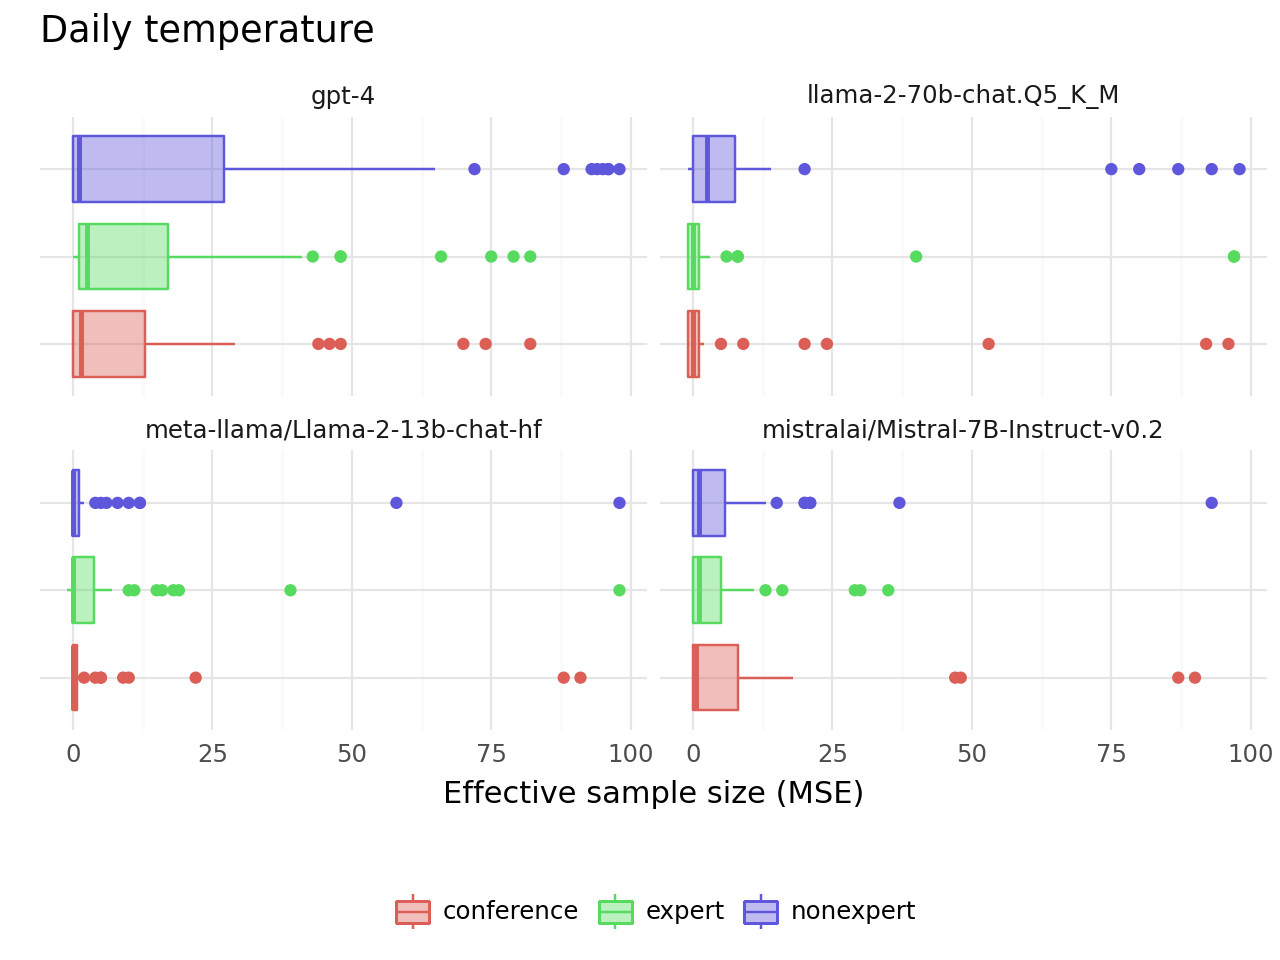

<Figure Size: (640 x 480)>

In [119]:
(
    ggplot(nig_priors) +
    aes('role', 'ess_mse', color='role', fill=after_scale('color+"66"')) +
    geom_boxplot() +
    labs(title='Daily temperature', x = '', y = 'Effective sample size (MSE)', fill='', colour='') +
    facet_wrap('~model') +
    coord_flip() +
    theme_minimal() +
    theme(legend_position='bottom', axis_text_y=element_blank())
)

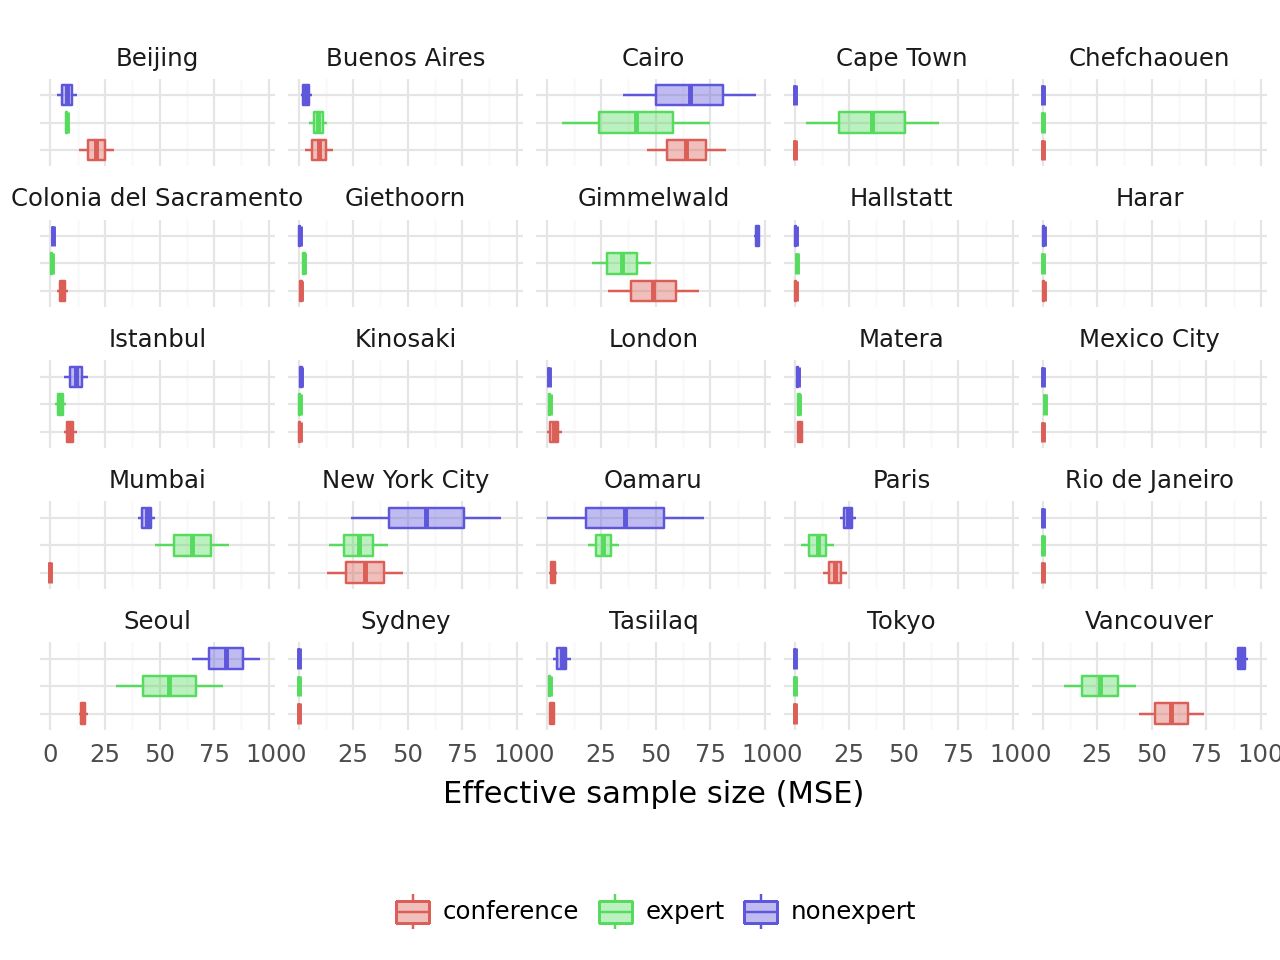

<Figure Size: (640 x 480)>

In [125]:
(
    ggplot(nig_priors[nig_priors.model=='gpt-4']) +
    aes('role', 'ess_mse', color='role', fill=after_scale('color+"66"')) +
    geom_boxplot() +
    coord_flip() +
    facet_wrap('~field') +
    labs(title='', x='', y = 'Effective sample size (MSE)', colour='') +
    theme_minimal() +
    theme(legend_position='bottom', axis_text_y=element_blank())
)

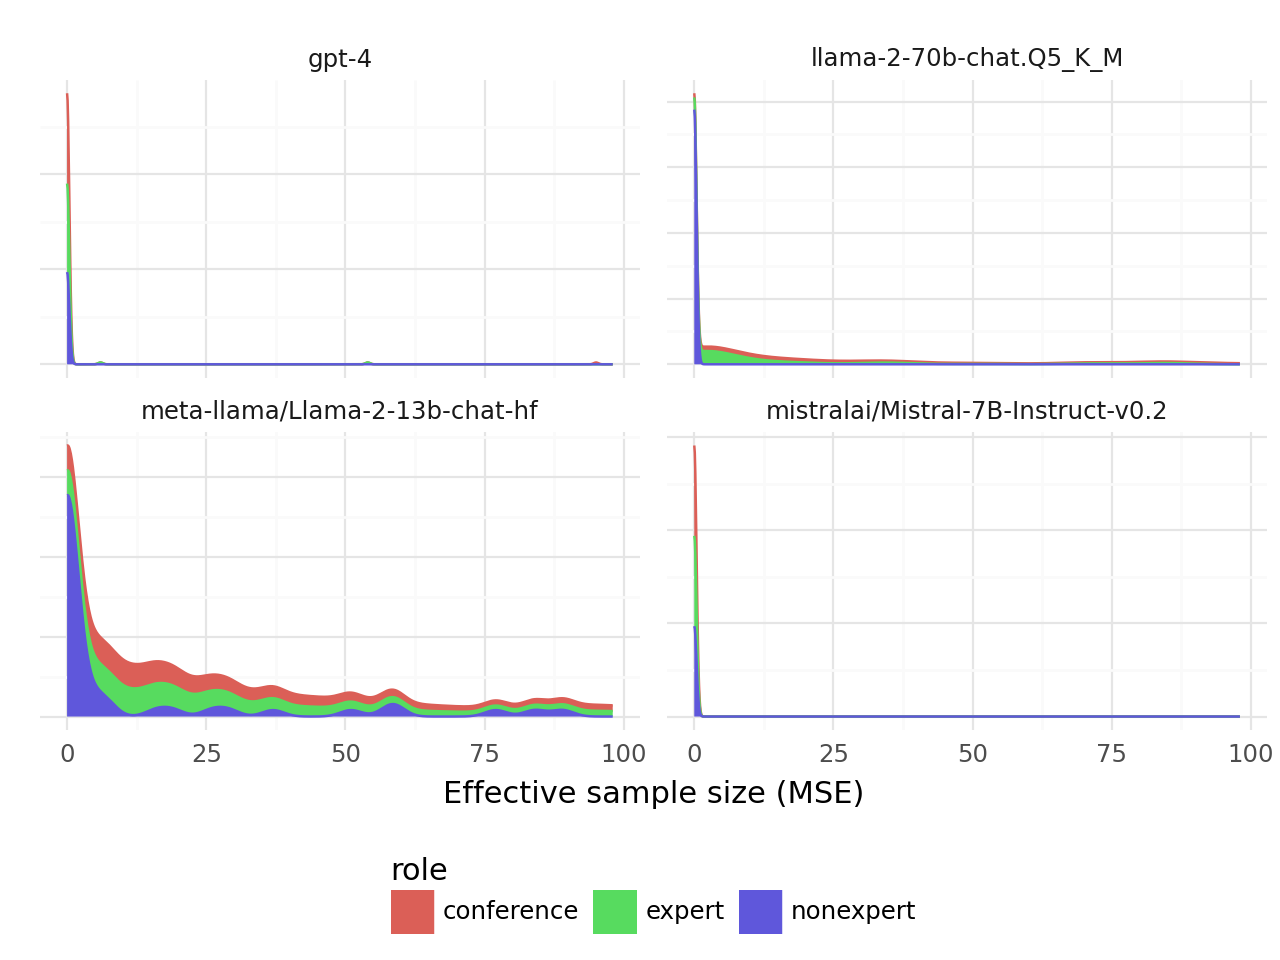

<Figure Size: (640 x 480)>

In [96]:
(
    ggplot(gam_priors) +
    aes('ess_mse', fill='role', colour='role') +
    geom_density(position='stack') +
    facet_wrap('~model', scales='free_y') +
    labs(title='', y = '', x = 'Effective sample size (MSE)') +
    theme_minimal() +
    theme(legend_position='bottom', axis_text_y=element_blank())
)

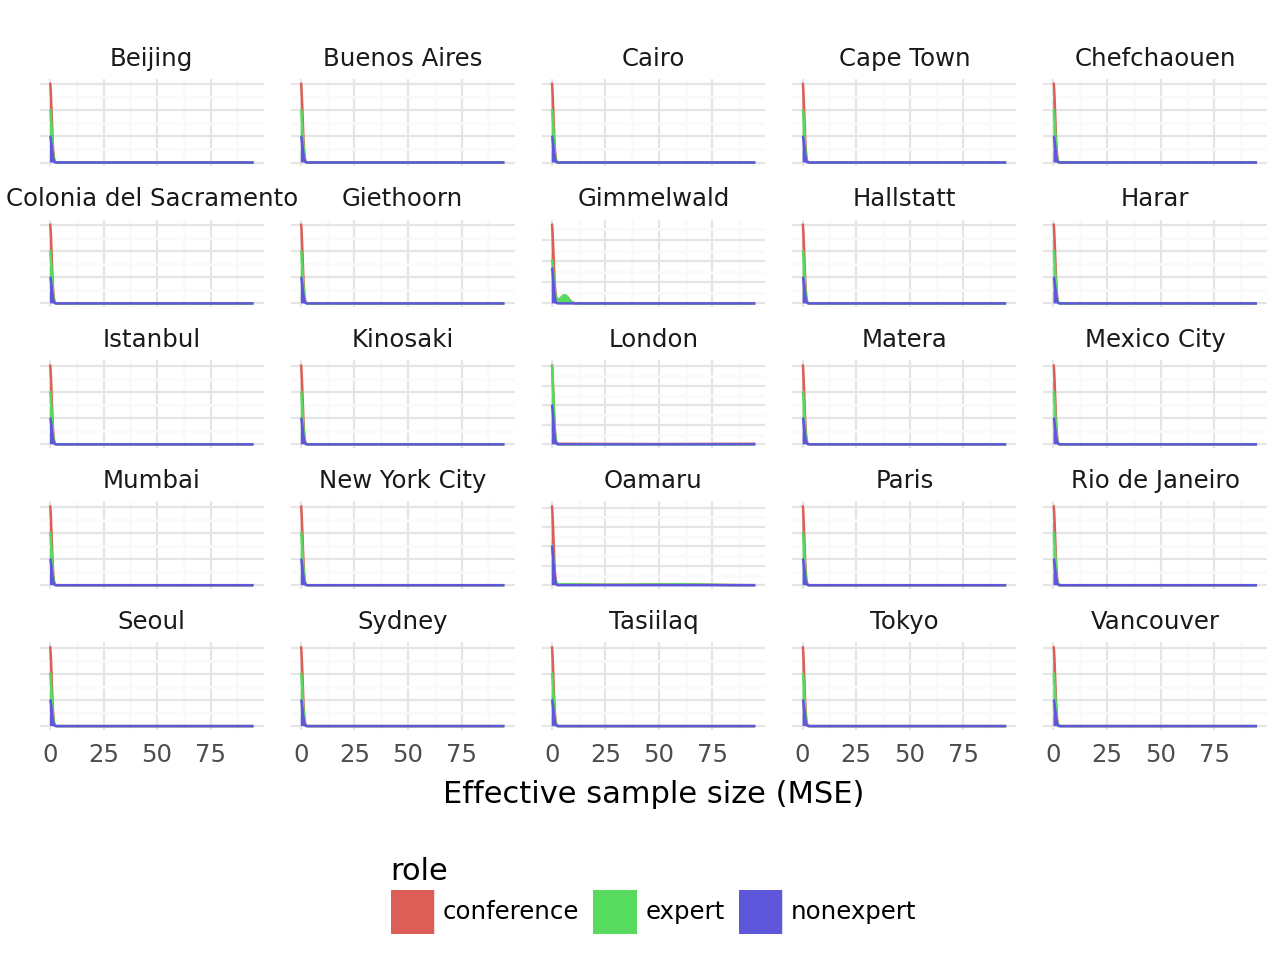

<Figure Size: (640 x 480)>

In [97]:
(
    ggplot(gam_priors[gam_priors.model=='gpt-4']) +
    aes('ess_mse', fill='role', colour='role') +
    geom_density(position='stack') +
    facet_wrap('~field', scales='free_y') +
    labs(title='', y = '', x = 'Effective sample size (MSE)') +
    theme_minimal() +
    theme(legend_position='bottom', axis_text_y=element_blank())
)

## Combined plot

In [98]:
(
    ggplot(pd.concat([nig_priors) +
    aes('ess_mse', fill='role', colour='role') +
    geom_density(position='stack') +
    facet_wrap('~model', scales='free_y') +
    labs(title='', y = '', x = 'Effective sample size (MSE)') +
    theme_minimal() +
    theme(legend_position='bottom', axis_text_y=element_blank())
)

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (296548033.py, line 2)

# Predictive loss

In [ ]:
weather_df

In [ ]:
priors_df

In [ ]:
set(priors_df.model)

In [ ]:
from modules.evaluator import PriorEvaluator
from sklearn.model_selection import train_test_split

likelihood = {'normal_inverse_gamma': 'norm', 'gamma': 'exp'}
parameters = {'normal_inverse_gamma': ['mean', 'precision', 'shape', 'scale'],
              'gamma': ['shape', 'scale']}
# train_test_split(X, y, test_size=0.2, random_state=42)

results_list = []
for index, row in priors_df.iterrows():
    family = likelihood[row.dist]
    city, target = row.field, row.target
    param_names = parameters[row.dist]
    train, test = train_test_split(weather_df[weather_df.city==city][target],
                                   test_size=0.1, random_state=42)
    param_dict = {key: row.params[key] for key in param_names}
    if 'precision' in param_dict:
        param_dict['variance'] = 1 / param_dict.pop('precision')
    evaluator = PriorEvaluator(family=family, train_data=train, test_data=test,
                               **param_dict)
    sample_sizes = np.unique(np.logspace(np.log2(2), np.log2(len(train)/2), 20, base=2, dtype=int))
    loss_df = pd.DataFrame(evaluator.evaluate(sample_sizes))
    loss_df = loss_df.assign(**row.to_dict())
    loss_df['index'] = index
    results_list.append(loss_df)
    
results_df = pd.concat(results_list, ignore_index=True)

In [ ]:
results_df.head()

In [ ]:
(
    ggplot(results_df[results_df.target == 'temperature']) + 
    aes('n', 'loss', colour='model', group='index') + 
    geom_line(aes(linetype='role')) + 
    facet_wrap('~ field', scales='free_y') + 
    scale_x_log10(minor_breaks = None) +
    scale_y_continuous(minor_breaks = None) +
    theme(legend_position='bottom', legend_title=element_blank()) +
    guides(colour = guide_legend(nrow=3, byrow=True),
           linetype = guide_legend(nrow=3)) +
    ggtitle('Daily temperature')
)

In [ ]:
(
    ggplot(results_df[results_df.target == 'precipitation']) + 
    aes('n', 'loss', colour='model', group='index') + 
    geom_line(aes(linetype='role')) + 
    facet_wrap('~ field', scales='free_y') + 
    scale_x_log10(minor_breaks = None) +
    scale_y_continuous(minor_breaks = None) +
    theme(legend_position='bottom', legend_title=element_blank()) +
    guides(colour = guide_legend(nrow=3, byrow=True),
           linetype = guide_legend(nrow=3)) +
    ggtitle('Daily precipitation')
)

In [ ]:
results_df[(results_df.target == 'precipitation') &
           (results_df.field == 'Harar')].sort_values('loss')

# Generic tasks

In [ ]:
tasks_filepath = data_dirpath / 'tasks.csv'
tasks_output_filepath = data_dirpath / 'output/elicitation/anytask-server.ndjson'

In [ ]:
tasks_list = pd.read_csv(tasks_filepath)
tasks_list.head()

In [ ]:
tasks_output = read_ndjson(tasks_output_filepath)
tasks_output.head()

In [ ]:
tasks_merged = tasks_output.merge(tasks_list, left_on='task_index', right_index=True)
tasks_merged.head()

In [ ]:
tasks_merged = pd.concat([tasks_merged, pd.json_normalize(tasks_merged.params)], axis=1)
tasks_merged.head()

In [ ]:
tasks_merged['ess_beta'] = tasks_merged.alpha + tasks_merged.beta
tasks_merged[tasks_merged.dist=='beta'].groupby(['model', 'Category']).ess_beta.mean()


In [ ]:
def abbr_model(model_name):
    lookup = {'mistralai/Mistral-7B-Instruct-v0.2': 'Mistral-7B-Instruct',
              'llama-2-70b-chat.Q5_K_M': 'Llama-2-70B',
              'meta-llama/Llama-2-13b-chat-hf': 'Llama-2-13B',
              'gpt-4': 'GPT-4'}
    if model_name in lookup:
        return lookup[model_name]
    else:
        return model_name

tasks_merged['model_abbr'] = tasks_merged.model.apply(abbr_model)

(
    ggplot(tasks_merged[(tasks_merged.dist=='beta') & (tasks_merged.alpha + tasks_merged.beta < 2500)]) +
    aes('model', 'alpha+beta', fill='model_abbr', colour='model_abbr') +
    geom_boxplot() +
    #geom_jitter(alpha=.3) +
    #facet_wrap('~model', scales='free') +
    coord_flip() +
    theme_minimal() +
    labs(x='', fill='', colour='') +
    facet_wrap('~Category') +
    theme(axis_text_y=element_blank(),
          legend_position='bottom',
          figure_size=(8, 3),
          legend_spacing=0,
          legend_entry_spacing_y=0,
          legend_margin=0,
          legend_title=element_blank()) +
    guides(fill = guide_legend(nrow=1, title=''))
)

In [ ]:
(
    ggplot(tasks_merged[(tasks_merged.dist=='normal')]) +
    aes('model', 'mean/std_dev', fill='model_abbr', colour='model_abbr') +
    geom_boxplot() +
    #geom_jitter(alpha=.3) +
    #facet_wrap('~model', scales='free') +
    coord_flip() +
    theme_minimal() +
    labs(x='', fill='', colour='') +
    facet_wrap('~Category') +
    theme(axis_text_y=element_blank(),
          legend_position='bottom',
          figure_size=(8, 3),
          legend_spacing=0,
          legend_entry_spacing_y=0,
          legend_margin=0,
          legend_title=element_blank()) +
    guides(fill = guide_legend(nrow=1, title=''))
)